## <center>RNN on a Time Series</center>

For these examples we're using data from the Federal Reserve Economic Database (FRED) concerning Sales of Beer, Wine, and Distilled Alcoholic Beverages in millions of dollars from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/S4248SM144NCEN

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = pd.read_csv('C:/Users/Lenovo/Desktop/Python/Deep Learning/Data Sets/PyTorch/TimeSeriesData/Alcohol_Sales.csv',
                  index_col=0,parse_dates=True)
df.columns = ["Production"]
df.head()

,Production
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [3]:
df.isnull().sum()

Production    0
dtype: int64

#### Plotting time series data
We can add titles, axis labels, and other features to the plot.<br>
We're going to tighten the x-axis to fit the width of the actual data with <tt>plt.autoscale(axis='x',tight=True)</tt>.<br>
Alternatively you could set your own limits with <tt>plt.xlim(pd.Timestamp('1992-01-01'), pd.Timestamp('2019-01-01'))</tt> or some other values.

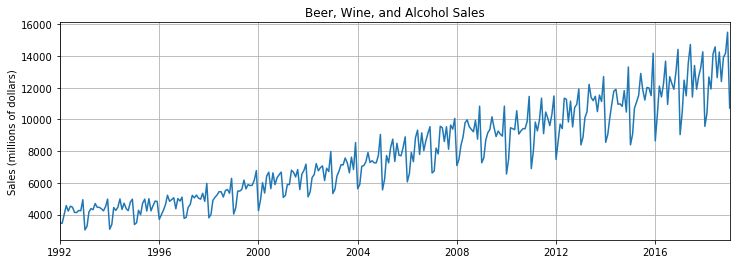

In [4]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Production'])
plt.show()

### Prepare the data
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [5]:
y = df['Production'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [6]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

It's worth noting that in our previous exercise the train and test sets were tensors. Here they're numpy arrays. This is because one of the steps we're about to perform outputs an array, and we'd have to turn it into a tensor anyway.

#### Normalize the data
The normailization will be performed using a MinMax scaler, but ranging from -1 to 1

In [7]:
from sklearn.preprocessing import MinMaxScaler

c:\Users\Lenovo\anaconda3\envs\pytorchenv\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [9]:
train_norm.min(), train_norm.max(), train_norm.mean()

(-1.0, 1.0, -0.2041940178388313)

In [10]:
type(train_norm)

numpy.ndarray

## Prepare data for LSTM
Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [11]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  

301

In [15]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

### Define the model
This time we'll use an LSTM layer of size (1,100).

In [16]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

In [17]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

### Train the model

In [18]:
epochs = 100

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    

Epoch:  1 Loss: 0.25314361
Epoch:  2 Loss: 0.37523884
Epoch:  3 Loss: 0.39012104
Epoch:  4 Loss: 0.34949693
Epoch:  5 Loss: 0.33077896
Epoch:  6 Loss: 0.33230731
Epoch:  7 Loss: 0.32667685
Epoch:  8 Loss: 0.32077038
Epoch:  9 Loss: 0.30651760
Epoch: 10 Loss: 0.29517013
Epoch: 11 Loss: 0.26913968
Epoch: 12 Loss: 0.25979361
Epoch: 13 Loss: 0.24600130
Epoch: 14 Loss: 0.22227792
Epoch: 15 Loss: 0.18593504
Epoch: 16 Loss: 0.18445951
Epoch: 17 Loss: 0.17433228
Epoch: 18 Loss: 0.25821066
Epoch: 19 Loss: 0.22416227
Epoch: 20 Loss: 0.23134166
Epoch: 21 Loss: 0.19803584
Epoch: 22 Loss: 0.19261685
Epoch: 23 Loss: 0.21316402
Epoch: 24 Loss: 0.16391523
Epoch: 25 Loss: 0.14361209
Epoch: 26 Loss: 0.12903365
Epoch: 27 Loss: 0.12049814
Epoch: 28 Loss: 0.01258187
Epoch: 29 Loss: 0.00303197
Epoch: 30 Loss: 0.08308884
Epoch: 31 Loss: 0.02775884
Epoch: 32 Loss: 0.00841987
Epoch: 33 Loss: 0.05500283
Epoch: 34 Loss: 0.01381821
Epoch: 35 Loss: 0.03175719
Epoch: 36 Loss: 0.00286627
Epoch: 37 Loss: 0.00166823
E

### Run predictions and compare to known test set

In [19]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [20]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.17892052233219147,
 0.7949932813644409,
 0.4864506721496582,
 0.8629130721092224,
 1.1898083686828613,
 0.45082223415374756,
 0.6767447590827942,
 0.7144804000854492,
 0.6400344967842102,
 0.7970378398895264,
 1.0615057945251465,
 0.11301019787788391]

### Invert the normalization
We want to compare our test predictions to the original data, so we need to undo the previous normalization step. Note that <tt>inverse_transform</tt> uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [22]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[ 9927.09559538],
       [13530.81319934],
       [11725.99320674],
       [13928.1100153 ],
       [15840.28405261],
       [11517.58465868],
       [12839.11846825],
       [13059.8531003 ],
       [12624.38178894],
       [13542.77284443],
       [15089.77814507],
       [ 9541.55315249]])

In [23]:
df['Production'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: Production, dtype: int64

It looks like our predictions weren't that far off!


Our original data contains a datetime index, but our predicted values do not. We can create a range of dates using NumPy that are spaced one month apart using <tt>dtype='datetime64[M]'</tt>, and then store them with day values to match our dataset with <tt>.astype('datetime64[D]')</tt>.

In [24]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

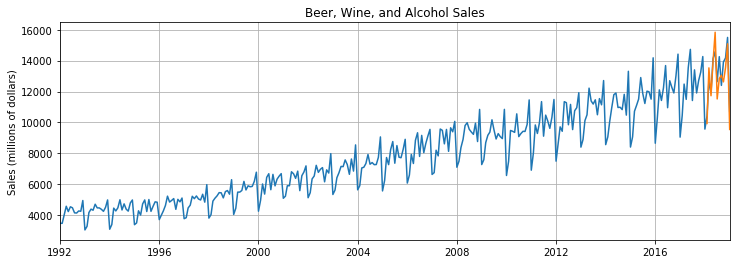

In [25]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Production'])
plt.plot(x,true_predictions)
plt.show()

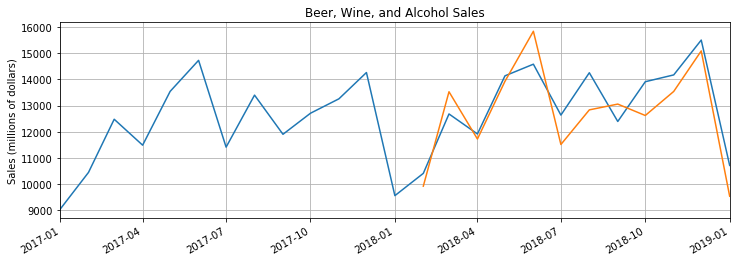

In [27]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df.loc['2017-01-01':, "Production"])
plt.plot(x,true_predictions)
plt.show()

### Forecast into an unknown future
This time we'll continue training the model using the entire dataset, and predict 12 steps into the future.

In [28]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')


Epoch:  1 Loss: 0.01526729
Epoch:  2 Loss: 0.02673574
Epoch:  3 Loss: 0.01420291
Epoch:  4 Loss: 0.01441281
Epoch:  5 Loss: 0.01399512
Epoch:  6 Loss: 0.01370639
Epoch:  7 Loss: 0.01252321
Epoch:  8 Loss: 0.01391466
Epoch:  9 Loss: 0.00776201
Epoch: 10 Loss: 0.00785462
Epoch: 11 Loss: 0.00860032
Epoch: 12 Loss: 0.01010237
Epoch: 13 Loss: 0.00855806
Epoch: 14 Loss: 0.00666134
Epoch: 15 Loss: 0.01003196
Epoch: 16 Loss: 0.00693797
Epoch: 17 Loss: 0.00860030
Epoch: 18 Loss: 0.00733370
Epoch: 19 Loss: 0.00810862
Epoch: 20 Loss: 0.00578879
Epoch: 21 Loss: 0.00650829
Epoch: 22 Loss: 0.00572615
Epoch: 23 Loss: 0.00626841
Epoch: 24 Loss: 0.00544463
Epoch: 25 Loss: 0.00759277
Epoch: 26 Loss: 0.00557913
Epoch: 27 Loss: 0.00300668
Epoch: 28 Loss: 0.00696337
Epoch: 29 Loss: 0.00381178
Epoch: 30 Loss: 0.00661278
Epoch: 31 Loss: 0.00611819
Epoch: 32 Loss: 0.00164434
Epoch: 33 Loss: 0.00227886
Epoch: 34 Loss: 0.00272366
Epoch: 35 Loss: 0.00405031
Epoch: 36 Loss: 0.00999437
Epoch: 37 Loss: 0.00460435
E

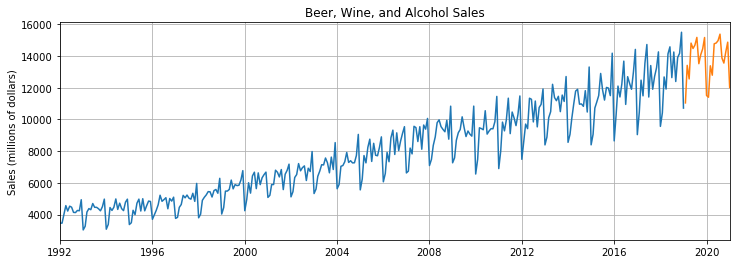

In [30]:
window_size = 12
future = 24

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2021-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Production'])
plt.plot(x,true_predictions[window_size:])
plt.show()

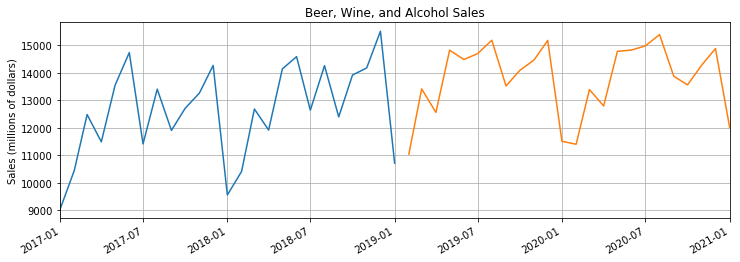

In [31]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df.loc['2017-01-01':, "Production"])
plt.plot(x,true_predictions[window_size:])
plt.show()